# Reccomendation System for Steam Game - Collaborative Filtering

- Author    : Muhammad Aditya Bayhaqie
- Practice  : Machine Learning Terapan (Dicoding)
- Dataset   : [Steam Games Kaggle](https://www.kaggle.com/datasets/fronkongames/steam-games-dataset/data?select=games.csv)

## Data Understanding

Let's get our Data and Library!!

In [86]:
# Import library
import pandas as pd
import numpy as np
from zipfile import ZipFile
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from pathlib import Path
import matplotlib.pyplot as plt

In [87]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [88]:
! mkdir ~/.kaggle

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [89]:
!cp /content/drive/MyDrive/CollabData/kaggle_API/kaggle.json ~/.kaggle/kaggle.json

In [90]:
! chmod 600 ~/.kaggle/kaggle.json

In [91]:
!kaggle datasets download fronkongames/steam-games-dataset

Dataset URL: https://www.kaggle.com/datasets/fronkongames/steam-games-dataset
License(s): MIT
steam-games-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)


In [92]:
# !unzip steam-games-dataset.zip

### Data Assessment

In [93]:
games = pd.read_csv('/content/games.csv')

In [94]:
# Membaca dataset

df = games
df.head(5)

,AppID,Name,Release date,Estimated owners,Peak CCU,Required age,Price,DiscountDLC count,About the game,Supported languages,...,Average playtime two weeks,Median playtime forever,Median playtime two weeks,Developers,Publishers,Categories,Genres,Tags,Screenshots,Movies
20200,Galactic Bowling,"Oct 21, 2008",0 - 20000,0,0,19.99,0,0,Galactic Bowling is an exaggerated and stylize...,['English'],...,0,0,0,Perpetual FX Creative,Perpetual FX Creative,"Single-player,Multi-player,Steam Achievements,...","Casual,Indie,Sports","Indie,Casual,Sports,Bowling",https://cdn.akamai.steamstatic.com/steam/apps/...,http://cdn.akamai.steamstatic.com/steam/apps/2...
655370,Train Bandit,"Oct 12, 2017",0 - 20000,0,0,0.99,0,0,THE LAW!! Looks to be a showdown atop a train....,"['English', 'French', 'Italian', 'German', 'Sp...",...,0,0,0,Rusty Moyher,Wild Rooster,"Single-player,Steam Achievements,Full controll...","Action,Indie","Indie,Action,Pixel Graphics,2D,Retro,Arcade,Sc...",https://cdn.akamai.steamstatic.com/steam/apps/...,http://cdn.akamai.steamstatic.com/steam/apps/2...
1732930,Jolt Project,"Nov 17, 2021",0 - 20000,0,0,4.99,0,0,Jolt Project: The army now has a new robotics ...,"['English', 'Portuguese - Brazil']",...,0,0,0,Campião Games,Campião Games,Single-player,"Action,Adventure,Indie,Strategy",NaN,https://cdn.akamai.steamstatic.com/steam/apps/...,http://cdn.akamai.steamstatic.com/steam/apps/2...
1355720,Henosis™,"Jul 23, 2020",0 - 20000,0,0,5.99,0,0,HENOSIS™ is a mysterious 2D Platform Puzzler w...,"['English', 'French', 'Italian', 'German', 'Sp...",...,0,0,0,Odd Critter Games,Odd Critter Games,"Single-player,Full controller support","Adventure,Casual,Indie","2D Platformer,Atmospheric,Surreal,Mystery,Puzz...",https://cdn.akamai.steamstatic.com/steam/apps/...,http://cdn.akamai.steamstatic.com/steam/apps/2...
1139950,Two Weeks in Painland,"Feb 3, 2020",0 - 20000,0,0,0.00,0,0,ABOUT THE GAME Play as a hacker who has arrang...,"['English', 'Spanish - Spain']",...,0,0,0,Unusual Games,Unusual Games,"Single-player,Steam Achievements","Adventure,Indie","Indie,Adventure,Nudity,Violent,Sexual Content,...",https://cdn.akamai.steamstatic.com/steam/apps/...,http://cdn.akamai.steamstatic.com/steam/apps/2...


Dari data tersebut, Dapat disimpulkan bahwa Terjadi pergeseran konten data dari kolom `AppID` hingga `DiscountDLCcount`, kita akan rename tiap kolom tersebut

In [95]:
# Rename columns
df = df.rename(columns={
    'Price': 'DiscountDLC count',
    'Required age' : 'Price',
    'Peak CCU': 'Required age',
    'Estimated owners': 'Peak CCU',
    'Release date': 'Estimated owners',
    'Name': 'Release date',
    'AppID': 'Name',
})

# Reindex the DataFrame
df = df.reset_index(drop=True)

df.head(5)

,Name,Release date,Estimated owners,Peak CCU,Required age,Price,DiscountDLC count,DiscountDLC count,About the game,Supported languages,...,Average playtime two weeks,Median playtime forever,Median playtime two weeks,Developers,Publishers,Categories,Genres,Tags,Screenshots,Movies
0,Galactic Bowling,"Oct 21, 2008",0 - 20000,0,0,19.99,0,0,Galactic Bowling is an exaggerated and stylize...,['English'],...,0,0,0,Perpetual FX Creative,Perpetual FX Creative,"Single-player,Multi-player,Steam Achievements,...","Casual,Indie,Sports","Indie,Casual,Sports,Bowling",https://cdn.akamai.steamstatic.com/steam/apps/...,http://cdn.akamai.steamstatic.com/steam/apps/2...
1,Train Bandit,"Oct 12, 2017",0 - 20000,0,0,0.99,0,0,THE LAW!! Looks to be a showdown atop a train....,"['English', 'French', 'Italian', 'German', 'Sp...",...,0,0,0,Rusty Moyher,Wild Rooster,"Single-player,Steam Achievements,Full controll...","Action,Indie","Indie,Action,Pixel Graphics,2D,Retro,Arcade,Sc...",https://cdn.akamai.steamstatic.com/steam/apps/...,http://cdn.akamai.steamstatic.com/steam/apps/2...
2,Jolt Project,"Nov 17, 2021",0 - 20000,0,0,4.99,0,0,Jolt Project: The army now has a new robotics ...,"['English', 'Portuguese - Brazil']",...,0,0,0,Campião Games,Campião Games,Single-player,"Action,Adventure,Indie,Strategy",NaN,https://cdn.akamai.steamstatic.com/steam/apps/...,http://cdn.akamai.steamstatic.com/steam/apps/2...
3,Henosis™,"Jul 23, 2020",0 - 20000,0,0,5.99,0,0,HENOSIS™ is a mysterious 2D Platform Puzzler w...,"['English', 'French', 'Italian', 'German', 'Sp...",...,0,0,0,Odd Critter Games,Odd Critter Games,"Single-player,Full controller support","Adventure,Casual,Indie","2D Platformer,Atmospheric,Surreal,Mystery,Puzz...",https://cdn.akamai.steamstatic.com/steam/apps/...,http://cdn.akamai.steamstatic.com/steam/apps/2...
4,Two Weeks in Painland,"Feb 3, 2020",0 - 20000,0,0,0.00,0,0,ABOUT THE GAME Play as a hacker who has arrang...,"['English', 'Spanish - Spain']",...,0,0,0,Unusual Games,Unusual Games,"Single-player,Steam Achievements","Adventure,Indie","Indie,Adventure,Nudity,Violent,Sexual Content,...",https://cdn.akamai.steamstatic.com/steam/apps/...,http://cdn.akamai.steamstatic.com/steam/apps/2...


In [96]:
# Reindex the DataFrame
df = df.reset_index(drop=True)

# Remove duplicate 'DiscountDLC count' column, keeping the first
df = df.loc[:,~df.columns.duplicated()]

df.head(5)

,Name,Release date,Estimated owners,Peak CCU,Required age,Price,DiscountDLC count,About the game,Supported languages,Full audio languages,...,Average playtime two weeks,Median playtime forever,Median playtime two weeks,Developers,Publishers,Categories,Genres,Tags,Screenshots,Movies
0,Galactic Bowling,"Oct 21, 2008",0 - 20000,0,0,19.99,0,Galactic Bowling is an exaggerated and stylize...,['English'],[],...,0,0,0,Perpetual FX Creative,Perpetual FX Creative,"Single-player,Multi-player,Steam Achievements,...","Casual,Indie,Sports","Indie,Casual,Sports,Bowling",https://cdn.akamai.steamstatic.com/steam/apps/...,http://cdn.akamai.steamstatic.com/steam/apps/2...
1,Train Bandit,"Oct 12, 2017",0 - 20000,0,0,0.99,0,THE LAW!! Looks to be a showdown atop a train....,"['English', 'French', 'Italian', 'German', 'Sp...",[],...,0,0,0,Rusty Moyher,Wild Rooster,"Single-player,Steam Achievements,Full controll...","Action,Indie","Indie,Action,Pixel Graphics,2D,Retro,Arcade,Sc...",https://cdn.akamai.steamstatic.com/steam/apps/...,http://cdn.akamai.steamstatic.com/steam/apps/2...
2,Jolt Project,"Nov 17, 2021",0 - 20000,0,0,4.99,0,Jolt Project: The army now has a new robotics ...,"['English', 'Portuguese - Brazil']",[],...,0,0,0,Campião Games,Campião Games,Single-player,"Action,Adventure,Indie,Strategy",NaN,https://cdn.akamai.steamstatic.com/steam/apps/...,http://cdn.akamai.steamstatic.com/steam/apps/2...
3,Henosis™,"Jul 23, 2020",0 - 20000,0,0,5.99,0,HENOSIS™ is a mysterious 2D Platform Puzzler w...,"['English', 'French', 'Italian', 'German', 'Sp...",[],...,0,0,0,Odd Critter Games,Odd Critter Games,"Single-player,Full controller support","Adventure,Casual,Indie","2D Platformer,Atmospheric,Surreal,Mystery,Puzz...",https://cdn.akamai.steamstatic.com/steam/apps/...,http://cdn.akamai.steamstatic.com/steam/apps/2...
4,Two Weeks in Painland,"Feb 3, 2020",0 - 20000,0,0,0.00,0,ABOUT THE GAME Play as a hacker who has arrang...,"['English', 'Spanish - Spain']",[],...,0,0,0,Unusual Games,Unusual Games,"Single-player,Steam Achievements","Adventure,Indie","Indie,Adventure,Nudity,Violent,Sexual Content,...",https://cdn.akamai.steamstatic.com/steam/apps/...,http://cdn.akamai.steamstatic.com/steam/apps/2...


In [97]:
# Drop the 8th column ('DiscountDLC count')
df = df.drop(df.columns[7], axis=1)

# Display the updated DataFrame (optional)
df.head(5)

,Name,Release date,Estimated owners,Peak CCU,Required age,Price,DiscountDLC count,Supported languages,Full audio languages,Reviews,...,Average playtime two weeks,Median playtime forever,Median playtime two weeks,Developers,Publishers,Categories,Genres,Tags,Screenshots,Movies
0,Galactic Bowling,"Oct 21, 2008",0 - 20000,0,0,19.99,0,['English'],[],NaN,...,0,0,0,Perpetual FX Creative,Perpetual FX Creative,"Single-player,Multi-player,Steam Achievements,...","Casual,Indie,Sports","Indie,Casual,Sports,Bowling",https://cdn.akamai.steamstatic.com/steam/apps/...,http://cdn.akamai.steamstatic.com/steam/apps/2...
1,Train Bandit,"Oct 12, 2017",0 - 20000,0,0,0.99,0,"['English', 'French', 'Italian', 'German', 'Sp...",[],NaN,...,0,0,0,Rusty Moyher,Wild Rooster,"Single-player,Steam Achievements,Full controll...","Action,Indie","Indie,Action,Pixel Graphics,2D,Retro,Arcade,Sc...",https://cdn.akamai.steamstatic.com/steam/apps/...,http://cdn.akamai.steamstatic.com/steam/apps/2...
2,Jolt Project,"Nov 17, 2021",0 - 20000,0,0,4.99,0,"['English', 'Portuguese - Brazil']",[],NaN,...,0,0,0,Campião Games,Campião Games,Single-player,"Action,Adventure,Indie,Strategy",NaN,https://cdn.akamai.steamstatic.com/steam/apps/...,http://cdn.akamai.steamstatic.com/steam/apps/2...
3,Henosis™,"Jul 23, 2020",0 - 20000,0,0,5.99,0,"['English', 'French', 'Italian', 'German', 'Sp...",[],NaN,...,0,0,0,Odd Critter Games,Odd Critter Games,"Single-player,Full controller support","Adventure,Casual,Indie","2D Platformer,Atmospheric,Surreal,Mystery,Puzz...",https://cdn.akamai.steamstatic.com/steam/apps/...,http://cdn.akamai.steamstatic.com/steam/apps/2...
4,Two Weeks in Painland,"Feb 3, 2020",0 - 20000,0,0,0.00,0,"['English', 'Spanish - Spain']",[],NaN,...,0,0,0,Unusual Games,Unusual Games,"Single-player,Steam Achievements","Adventure,Indie","Indie,Adventure,Nudity,Violent,Sexual Content,...",https://cdn.akamai.steamstatic.com/steam/apps/...,http://cdn.akamai.steamstatic.com/steam/apps/2...


## Exploratory Data Analysis

### Univariate Exploratory Data Analysis

`Game` Variable

In [11]:
games.info()

<class 'pandas.core.frame.DataFrame'>
Index: 111452 entries, 20200 to 3183790
Data columns (total 39 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   AppID                       111446 non-null  object 
 1   Name                        111452 non-null  object 
 2   Release date                111452 non-null  object 
 3   Estimated owners            111452 non-null  int64  
 4   Peak CCU                    111452 non-null  int64  
 5   Required age                111452 non-null  float64
 6   Price                       111452 non-null  int64  
 7   DiscountDLC count           111452 non-null  int64  
 8   About the game              104969 non-null  object 
 9   Supported languages         111452 non-null  object 
 10  Full audio languages        111452 non-null  object 
 11  Reviews                     10624 non-null   object 
 12  Header image                111452 non-null  object 
 13  Website       

In [13]:
print('Banyak data game yang terdaftar: ', len(games.AppID.unique()))
print('Banyak game yang terdaftar: ', games.Name.unique())
print('List Game: ', games.Name.unique())

Banyak data game yang terdaftar:  110326
Banyak game yang terdaftar:  ['Oct 21, 2008' 'Oct 12, 2017' 'Nov 17, 2021' ... 'Apr 18, 2025'
 'Apr 19, 2025' 'Apr 21, 2025']
List Game:  ['Oct 21, 2008' 'Oct 12, 2017' 'Nov 17, 2021' ... 'Apr 18, 2025'
 'Apr 19, 2025' 'Apr 21, 2025']


Terdapat 615 data restoran yang unik dengan 12 jenis pembayaran yang diterima

## Data Preprocessing

`Restaurant` Merging

Untuk mempermudah model dalam mengolah data, kita akan menggabungkan data untuk mempermudah pemrosesannya nantinya

In [ ]:
# Menggabungkan seluruh placeID pada kategori Restaurant
resto_all = np.concatenate((
    accepts.placeID.unique(),
    cuisine.placeID.unique(),
    hours.placeID.unique(),
    parking.placeID.unique(),
    geo.placeID.unique()
))

# Mengurutkan data dan menghapus data yang sama
resto_all = np.sort(np.unique(resto_all))

print('Jumlah seluruh data restoran berdasarkan placeID: ', len(resto_all))

Jumlah seluruh data restoran berdasarkan placeID:  938


Setelah file pada kategori Restaurant digabung, kita memiliki 938 restoran yang unik.

`User` Merging

Untuk mempermudah model dalam mengolah data, kita akan menggabungkan data untuk mempermudah pemrosesannya nantinya

In [ ]:
# Menggabungkan seluruh userID
user_all = np.concatenate((
    usercuisine.userID.unique(),
    payment.userID.unique(),
    profile.userID.unique()
))

# Menghapus data yang sama kemudian mengurutkannya
user_all = np.sort(np.unique(user_all))

print('Jumlah seluruh user: ', len(user_all))

Jumlah seluruh user:  138


Kita hanya memiliki 138 data pengguna dari 938 restoran yang memiliki rating. Jauh lebih sedikit dibandingkan Restoran.

`Rating` Merging

Untuk mempermudah model dalam mengolah data, kita akan menggabungkan data untuk mempermudah pemrosesannya nantinya

In [ ]:
# Menggabungkan file accepts, geo, parking, hours ke dalam dataframe resto_info
resto_info = pd.concat([accepts, geo, parking, hours])

# Menggabungkan dataframe rating dengan resto_info berdasarkan nilai placeID
resto = pd.merge(rating, resto_info , on='placeID', how='left')
resto

,userID,placeID,rating,food_rating,service_rating,Rpayment,latitude,longitude,the_geom_meter,name,...,accessibility,price,url,Rambience,franchise,area,other_services,parking_lot,hours,days
0,U1077,135085,2,2,2,cash,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,U1077,135085,2,2,2,NaN,22.150802,-100.982680,0101000020957F00009F823DA6094858C18A2D4D37F9A4...,Tortas Locas Hipocampo,...,no_accessibility,medium,?,familiar,f,closed,none,NaN,NaN,NaN
2,U1077,135085,2,2,2,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,public,NaN,NaN
3,U1077,135085,2,2,2,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,00:00-00:00;,Mon;Tue;Wed;Thu;Fri;
4,U1077,135085,2,2,2,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,00:00-00:00;,Sat;
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8073,U1068,132660,0,0,0,NaN,23.752943,-99.164679,0101000020957F00003D7905C9DC8157C13FCD1AB7334E...,carnitas mata calle Emilio Portes Gil,...,completely,low,?,familiar,f,closed,none,NaN,NaN,NaN
8074,U1068,132660,0,0,0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,none,NaN,NaN
8075,U1068,132660,0,0,0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,00:00-23:30;,Mon;Tue;Wed;Thu;Fri;
8076,U1068,132660,0,0,0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,00:00-23:30;,Sat;


Kita memiliki banyak sekali missing value di sini. Mari kita cek lebih lanjut dengan kode berikut.

In [ ]:
# Cek missing value dengan fungsi isnull()
resto.isnull().sum()

,0
userID,0
placeID,0
rating,0
food_rating,0
service_rating,0
Rpayment,5781
latitude,6917
longitude,6917
the_geom_meter,6917
name,6917


Hanya fitur userID, placeID, rating, food_rating, dan service_rating saja yang memiliki 0 missing value. Selanjutnya, mari kita hitung jumlah rating, food_rating, dan service rating berdasarkan place.ID

In [ ]:
# Menghitung jumlah rating, food_rating, dan service kemudian menggabungkannya berdasarkan placeID
resto.groupby('placeID').sum()

,userID,rating,food_rating,service_rating,Rpayment,latitude,longitude,the_geom_meter,name,address,...,accessibility,price,url,Rambience,franchise,area,other_services,parking_lot,hours,days
placeID,,,,,,,,,,,,,,,,,,,,,
132560,U1067U1067U1067U1067U1067U1067U1082U1082U1082U...,12,24,6,cashcashcashcash,95.009216,-396.667653,0101000020957F0000FC60BDA8E88157C1B2C357D6DA4E...,puesto de gorditaspuesto de gorditaspuesto de ...,frente al tecnologicofrente al tecnologicofren...,...,no_accessibilityno_accessibilityno_accessibili...,lowlowlowlow,????,familiarfamiliarfamiliarfamiliar,ffff,openopenopenopen,nonenonenonenone,publicpublicpublicpublic,08:00-12:00;00:00-00:00;00:00-00:00;08:00-12:0...,Mon;Tue;Wed;Thu;Fri;Sat;Sun;Mon;Tue;Wed;Thu;Fr...
132561,U1026U1026U1026U1026U1026U1129U1129U1129U1129U...,15,20,20,0,94.907276,-396.506024,0101000020957F000004457BB7AA8657C15F10835CD944...,cafe ambarcafe ambarcafe ambarcafe ambar,????,...,completelycompletelycompletelycompletely,lowlowlowlow,????,familiarfamiliarfamiliarfamiliar,ffff,closedclosedclosedclosed,nonenonenonenone,nonenonenonenone,00:00-23:30;00:00-23:30;00:00-23:30;00:00-23:3...,Mon;Tue;Wed;Thu;Fri;Sat;Sun;Mon;Tue;Wed;Thu;Fr...
132564,U1060U1060U1060U1060U1060U1080U1080U1080U1080U...,25,25,30,0,94.923698,-396.580739,0101000020957F0000EA4F00C5A08557C140085474D949...,churchschurchschurchschurchs,????,...,completelycompletelycompletelycompletely,lowlowlowlow,????,familiarfamiliarfamiliarfamiliar,ffff,closedclosedclosedclosed,nonenonenonenone,nonenonenonenone,00:00-23:30;00:00-23:30;00:00-23:30;00:00-23:3...,Mon;Tue;Wed;Thu;Fri;Sat;Sun;Mon;Tue;Wed;Thu;Fr...
132572,U1108U1108U1108U1108U1108U1108U1055U1055U1055U...,90,90,84,cashcashcashcashcashcashcashcashcashcashcashca...,332.124707,-1514.890677,0101000020957F00005D19BF45294958C18FF7F8E260A8...,Cafe ChairesCafe ChairesCafe ChairesCafe Chair...,???????????????,...,completelycompletelycompletelycompletelycomple...,lowlowlowlowlowlowlowlowlowlowlowlowlowlowlow,???????????????,familiarfamiliarfamiliarfamiliarfamiliarfamili...,fffffffffffffff,closedclosedclosedclosedclosedclosedclosedclos...,nonenonenonenonenonenonenonenonenonenonenoneno...,yesyesyesyesyesyesyesyesyesyesyesyesyesyesyes,00:00-23:30;00:00-23:30;00:00-23:30;00:00-23:3...,Mon;Tue;Wed;Thu;Fri;Sat;Sun;Mon;Tue;Wed;Thu;Fr...
132583,U1044U1044U1044U1044U1044U1044U1118U1118U1118U...,24,24,30,cashVISAMasterCard-Eurocardbank_debit_cardscas...,75.689162,-396.937328,0101000020957F0000FBE7171F056F5AC1E8A6C0A5AF55...,McDonalds CentroMcDonalds CentroMcDonalds Cent...,Rayon sn col. CentroRayon sn col. CentroRayon ...,...,partiallypartiallypartiallypartially,lowlowlowlow,nononono,familiarfamiliarfamiliarfamiliar,tttt,closedclosedclosedclosed,nonenonenonenone,nonenonenonenone,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
135088,U1044U1044U1044U1044U1044U1044U1030U1030U1030U...,36,42,36,cashcashcashcashcashcash,113.256068,-595.319338,0101000020957F0000E14AD4DBC7765AC1F7B33C85B153...,Cafeteria cenidetCafeteria cenidetCafeteria ce...,Interior Internado Palmira SNInterior Internad...,...,no_accessibilityno_accessibilityno_accessibili...,lowlowlowlowlowlow,www.cenidet.edu.mxwww.cenidet.edu.mxwww.cenide...,quietquietquietquietquietquiet,ffffff,closedclosedclosedclosedclosedclosed,nonenonenonenonenonenone,publicpublicpublicpublicpublicpublic,09:00-16:00;00:00-00:00;00:00-00:00;09:00-16:0...,Mon;Tue;Wed;Thu;Fri;Sat;Sun;Mon;Tue;Wed;Thu;Fr...
135104,U1068U1068U1068U1068U1068U1068U1068U1068U1067U...,48,80,48,cashVISAMasterCard-EurocardcashVISAMasterCard-...,166.270875,-694.179039,0101000020957F00007CDF5EAFC58157C1645743B23E4F...,vipsvipsvipsvipsvipsvipsvips,???????,...,completelycompletelycompletelycompletelycomple...,mediummediummediummediummediummediummedium,???????,familiarfamiliarfamiliarfamiliarfamiliarfamili...,ttttttt,closedclosedclosedclosedclosedclosedclosed,varietyvarietyvarietyvarietyvarietyvarietyvariety,yesyesyesyesyesyesyes,00:00-23:30;00:00-23:30;00:

`Restaurant Name` Merging

Pertama, definisikan variabel all_resto_rate dengan variabel rating yang telah kita ketahui sebelumnya.

In [ ]:
# Definisikan dataframe rating ke dalam variabel all_resto_rate
all_resto_rate = rating
all_resto_rate

,userID,placeID,rating,food_rating,service_rating
0,U1077,135085,2,2,2
1,U1077,135038,2,2,1
2,U1077,132825,2,2,2
3,U1077,135060,1,2,2
4,U1068,135104,1,1,2
...,...,...,...,...,...
1156,U1043,132630,1,1,1
1157,U1011,132715,1,1,0
1158,U1068,132733,1,1,0
1159,U1068,132594,1,1,1


Selanjutnya, untuk mengetahui nama restoran dengan placeID tertentu, mari kita gabungkan data geo yang berisikan placeID dan nama resto berdasarkan placeID dan assign ke variabel all_resto_name

In [ ]:
# Menggabungkan all resto_rate dengan dataframe geo berdasarkan placeID
all_resto_name = pd.merge(all_resto_rate, geo[['placeID','name']], on='placeID', how='left')

# Print dataframe all_resto_name
all_resto_name

,userID,placeID,rating,food_rating,service_rating,name
0,U1077,135085,2,2,2,Tortas Locas Hipocampo
1,U1077,135038,2,2,1,Restaurant la Chalita
2,U1077,132825,2,2,2,puesto de tacos
3,U1077,135060,1,2,2,Restaurante Marisco Sam
4,U1068,135104,1,1,2,vips
...,...,...,...,...,...,...
1156,U1043,132630,1,1,1,palomo tec
1157,U1011,132715,1,1,0,tacos de la estacion
1158,U1068,132733,1,1,0,Little Cesarz
1159,U1068,132594,1,1,1,tacos de barbacoa enfrente del Tec


`Restaurant and Cuisine` Merging

Langkah selanjutnya adalah menggabungkan variabel all_resto_name yang kita peroleh dari tahapan sebelumnya dengan fitur masakan resto (cuisine).

In [ ]:
# Menggabungkan dataframe cuisine dengan all_resto_name dan memasukkannya ke dalam variabel all_resto
all_resto = pd.merge(all_resto_name, cuisine, on='placeID', how='left')
all_resto

,userID,placeID,rating,food_rating,service_rating,name,Rcuisine
0,U1077,135085,2,2,2,Tortas Locas Hipocampo,Fast_Food
1,U1077,135038,2,2,1,Restaurant la Chalita,NaN
2,U1077,132825,2,2,2,puesto de tacos,Mexican
3,U1077,135060,1,2,2,Restaurante Marisco Sam,Seafood
4,U1068,135104,1,1,2,vips,Mexican
...,...,...,...,...,...,...,...
1326,U1043,132630,1,1,1,palomo tec,Mexican
1327,U1011,132715,1,1,0,tacos de la estacion,Mexican
1328,U1068,132733,1,1,0,Little Cesarz,Pizzeria
1329,U1068,132594,1,1,1,tacos de barbacoa enfrente del Tec,Mexican


In [ ]:
# Mengubah userID menjadi list tanpa nilai yang sama
user_ids = df['userID'].unique().tolist()
print('list userID: ', user_ids)

# Melakukan encoding userID
user_to_user_encoded = {x: i for i, x in enumerate(user_ids)}
print('encoded userID : ', user_to_user_encoded)

# Melakukan proses encoding angka ke ke userID
user_encoded_to_user = {i: x for i, x in enumerate(user_ids)}
print('encoded angka ke userID: ', user_encoded_to_user)

list userID:  ['U1077', 'U1068', 'U1067', 'U1103', 'U1107', 'U1044', 'U1070', 'U1031', 'U1082', 'U1023', 'U1060', 'U1015', 'U1123', 'U1021', 'U1026', 'U1083', 'U1108', 'U1012', 'U1093', 'U1030', 'U1066', 'U1127', 'U1017', 'U1100', 'U1133', 'U1118', 'U1072', 'U1080', 'U1063', 'U1074', 'U1117', 'U1020', 'U1051', 'U1055', 'U1053', 'U1035', 'U1064', 'U1081', 'U1001', 'U1014', 'U1088', 'U1056', 'U1134', 'U1106', 'U1126', 'U1124', 'U1018', 'U1125', 'U1119', 'U1076', 'U1022', 'U1094', 'U1116', 'U1105', 'U1075', 'U1007', 'U1115', 'U1024', 'U1132', 'U1005', 'U1120', 'U1004', 'U1037', 'U1052', 'U1036', 'U1038', 'U1071', 'U1114', 'U1084', 'U1049', 'U1019', 'U1069', 'U1113', 'U1104', 'U1079', 'U1045', 'U1009', 'U1016', 'U1047', 'U1095', 'U1034', 'U1078', 'U1099', 'U1008', 'U1040', 'U1121', 'U1110', 'U1042', 'U1013', 'U1054', 'U1111', 'U1128', 'U1062', 'U1101', 'U1135', 'U1032', 'U1048', 'U1092', 'U1085', 'U1109', 'U1102', 'U1098', 'U1046', 'U1122', 'U1138', 'U1033', 'U1089', 'U1003', 'U1091', 'U10

In [ ]:
# Mengubah placeID menjadi list tanpa nilai yang sama
resto_ids = df['placeID'].unique().tolist()

# Melakukan proses encoding placeID
resto_to_resto_encoded = {x: i for i, x in enumerate(resto_ids)}

# Melakukan proses encoding angka ke placeID
resto_encoded_to_resto = {i: x for i, x in enumerate(resto_ids)}

In [ ]:
# Mapping userID ke dataframe user
df['user'] = df['userID'].map(user_to_user_encoded)

# Mapping placeID ke dataframe resto
df['resto'] = df['placeID'].map(resto_to_resto_encoded)

In [ ]:
# Mendapatkan jumlah user
num_users = len(user_to_user_encoded)
print(num_users)

# Mendapatkan jumlah resto
num_resto = len(resto_encoded_to_resto)
print(num_resto)

# Mengubah rating menjadi nilai float
df['rating'] = df['rating'].values.astype(np.float32)

# Nilai minimum rating
min_rating = min(df['rating'])

# Nilai maksimal rating
max_rating = max(df['rating'])

print('Number of User: {}, Number of Resto: {}, Min Rating: {}, Max Rating: {}'.format(
    num_users, num_resto, min_rating, max_rating
))

138
130
Number of User: 138, Number of Resto: 130, Min Rating: 0.0, Max Rating: 2.0


## Data Preparation

### Taking care on Missing Values

In [ ]:
# Mengecek missing value pada dataframe all_resto
all_resto.isnull().sum()

,0
userID,0
placeID,0
rating,0
food_rating,0
service_rating,0
name,0
Rcuisine,288


 Untuk saat ini kita akan drop saja missing value ini.

In [ ]:
# Membersihkan missing value dengan fungsi dropna()
all_resto_clean = all_resto.dropna()
all_resto_clean

,userID,placeID,rating,food_rating,service_rating,name,Rcuisine
0,U1077,135085,2,2,2,Tortas Locas Hipocampo,Fast_Food
2,U1077,132825,2,2,2,puesto de tacos,Mexican
3,U1077,135060,1,2,2,Restaurante Marisco Sam,Seafood
4,U1068,135104,1,1,2,vips,Mexican
5,U1068,132740,0,0,0,Carreton de Flautas y Migadas,Mexican
...,...,...,...,...,...,...,...
1325,U1043,132732,1,1,1,Taqueria EL amigo,Mexican
1326,U1043,132630,1,1,1,palomo tec,Mexican
1327,U1011,132715,1,1,0,tacos de la estacion,Mexican
1328,U1068,132733,1,1,0,Little Cesarz,Pizzeria


Let's Recheck

In [ ]:
# Mengecek kembali missing value pada variabel all_resto_clean
all_resto_clean.isnull().sum()

,0
userID,0
placeID,0
rating,0
food_rating,0
service_rating,0
name,0
Rcuisine,0


Merging and Formatting `Cuisine`

Pertama, mari kita cek ulang data setelah proses cleaning pada tahap sebelumnya. Kita buat variabel baru bernama fix_resto untuk menyimpan dataframe.

In [ ]:
# Mengurutkan resto berdasarkan PlaceID kemudian memasukkannya ke dalam variabel fix_resto
fix_resto = all_resto_clean.sort_values('placeID', ascending=True)
fix_resto

,userID,placeID,rating,food_rating,service_rating,name,Rcuisine
1288,U1050,132560,0,2,0,puesto de gorditas,Regional
42,U1082,132560,0,0,0,puesto de gorditas,Regional
1303,U1087,132560,1,2,1,puesto de gorditas,Regional
14,U1067,132560,1,0,0,puesto de gorditas,Regional
854,U1092,132572,1,0,0,Cafe Chaires,Cafeteria
...,...,...,...,...,...,...,...
189,U1055,135106,2,2,2,El Rincón de San Francisco,Mexican
1071,U1041,135109,1,2,1,Paniroles,Italian
99,U1030,135109,0,0,0,Paniroles,Italian
178,U1020,135109,2,2,1,Paniroles,Italian


In [ ]:
# Mengecek berapa jumlah fix_resto
len(fix_resto.placeID.unique())

95

In [ ]:
# Mengecek kategori masakan yang unik
fix_resto.Rcuisine.unique()

array(['Regional', 'Cafeteria', 'American', 'Mexican', 'Fast_Food',
       'Italian', 'Armenian', 'Pizzeria', 'Japanese', 'Vietnamese',
       'Family', 'International', 'Game', 'Burgers', 'Bakery', 'Bar',
       'Breakfast-Brunch', 'Bar_Pub_Brewery', 'Mediterranean',
       'Cafe-Coffee_Shop', 'Contemporary', 'Seafood', 'Chinese'],
      dtype=object)

Salah satu Cuisine yang menarik disini adalah `Game`, lets dive it more

In [ ]:
# Mengecek kategori masakan Game
fix_resto[fix_resto['Rcuisine'] == 'Game']

,userID,placeID,rating,food_rating,service_rating,name,Rcuisine
781,U1015,132851,1,1,1,KFC,Game
708,U1008,132851,1,1,1,KFC,Game
509,U1052,132851,1,0,2,KFC,Game
1188,U1131,132851,2,2,2,KFC,Game
770,U1037,132851,2,2,1,KFC,Game
764,U1111,132851,2,1,0,KFC,Game
574,U1069,132851,1,0,0,KFC,Game


Okay thats from KFC, mungkin makanan dengan hadiah? Let's Check any data containing `KFC` dan kita cek `Rcuisine`

In [ ]:
# Mengecek kategori masakan pada nama restoran KFC
fix_resto[fix_resto['name'] == 'KFC']

,userID,placeID,rating,food_rating,service_rating,name,Rcuisine
573,U1069,132851,1,0,0,KFC,American
781,U1015,132851,1,1,1,KFC,Game
708,U1008,132851,1,1,1,KFC,Game
780,U1015,132851,1,1,1,KFC,American
763,U1111,132851,2,1,0,KFC,American
508,U1052,132851,1,0,2,KFC,American
509,U1052,132851,1,0,2,KFC,Game
1188,U1131,132851,2,2,2,KFC,Game
1187,U1131,132851,2,2,2,KFC,American
769,U1037,132851,2,2,1,KFC,American


KFC memiliki dua kategori masakan yang berbeda, `Game` dan `American`. Tentu ini harus diperbaiki.

In [ ]:
# Mengubah nama kategori masakan ‘Game’ menjadi ‘American’
fix_resto = fix_resto.replace('Game', 'American')
fix_resto[fix_resto['name'] == 'KFC']

,userID,placeID,rating,food_rating,service_rating,name,Rcuisine
573,U1069,132851,1,0,0,KFC,American
781,U1015,132851,1,1,1,KFC,American
708,U1008,132851,1,1,1,KFC,American
780,U1015,132851,1,1,1,KFC,American
763,U1111,132851,2,1,0,KFC,American
508,U1052,132851,1,0,2,KFC,American
509,U1052,132851,1,0,2,KFC,American
1188,U1131,132851,2,2,2,KFC,American
1187,U1131,132851,2,2,2,KFC,American
769,U1037,132851,2,2,1,KFC,American


Now, the data has been cleaned, mari kita Prepared datanya!

In [ ]:
# Membuat variabel preparation yang berisi dataframe fix_resto kemudian mengurutkan berdasarkan placeID
preparation = fix_resto
preparation.sort_values('placeID')

,userID,placeID,rating,food_rating,service_rating,name,Rcuisine
1288,U1050,132560,0,2,0,puesto de gorditas,Regional
42,U1082,132560,0,0,0,puesto de gorditas,Regional
14,U1067,132560,1,0,0,puesto de gorditas,Regional
1303,U1087,132560,1,2,1,puesto de gorditas,Regional
1055,U1061,132572,1,2,2,Cafe Chaires,Cafeteria
...,...,...,...,...,...,...,...
189,U1055,135106,2,2,2,El Rincón de San Francisco,Mexican
1071,U1041,135109,1,2,1,Paniroles,Italian
99,U1030,135109,0,0,0,Paniroles,Italian
178,U1020,135109,2,2,1,Paniroles,Italian


### Dropping Duplicates

In [ ]:
# Membuang data duplikat pada variabel preparation
preparation = preparation.drop_duplicates('placeID')
preparation

,userID,placeID,rating,food_rating,service_rating,name,Rcuisine
1288,U1050,132560,0,2,0,puesto de gorditas,Regional
854,U1092,132572,1,0,0,Cafe Chaires,Cafeteria
27,U1044,132583,1,2,1,McDonalds Centro,American
148,U1063,132584,2,1,1,Gorditas Dona Tota,Mexican
1304,U1087,132594,1,2,1,tacos de barbacoa enfrente del Tec,Mexican
...,...,...,...,...,...,...,...
1016,U1019,135086,0,0,0,Mcdonalds Parque Tangamanga,Burgers
179,U1051,135088,1,1,1,Cafeteria cenidet,Cafeteria
4,U1068,135104,1,1,2,vips,Mexican
807,U1135,135106,0,0,0,El Rincón de San Francisco,Mexican


### Data Conversion

In [ ]:
# Mengonversi data series ‘placeID’ menjadi dalam bentuk list
resto_id = preparation['placeID'].tolist()

# Mengonversi data series ‘Name’ menjadi dalam bentuk list
resto_name = preparation['name'].tolist()

# Mengonversi data series ‘Rcuisine’ menjadi dalam bentuk list
resto_cuisine = preparation['Rcuisine'].tolist()

print(len(resto_id))
print(len(resto_name))
print(len(resto_cuisine))

95
95
95


### Dictionary Making

Kita akan membuat dictionary untuk menentukan pasangan key-value pada data resto_id, resto_name, dan resto_cuisine yang telah kita siapkan sebelumnya.

In [ ]:
# Membuat dictionary untuk data ‘resto_id’, ‘resto_name’, dan ‘cuisine’
resto_new = pd.DataFrame({
    'id': resto_id,
    'resto_name': resto_name,
    'cuisine': resto_cuisine
})
resto_new

,id,resto_name,cuisine
0,132560,puesto de gorditas,Regional
1,132572,Cafe Chaires,Cafeteria
2,132583,McDonalds Centro,American
3,132584,Gorditas Dona Tota,Mexican
4,132594,tacos de barbacoa enfrente del Tec,Mexican
...,...,...,...
90,135086,Mcdonalds Parque Tangamanga,Burgers
91,135088,Cafeteria cenidet,Cafeteria
92,135104,vips,Mexican
93,135106,El Rincón de San Francisco,Mexican


### Data Splitting

In [ ]:
# Mengacak dataset
df = df.sample(frac=1, random_state=42)
df

,userID,placeID,rating,food_rating,service_rating,user,resto
538,U1052,132870,1.0,1,1,63,116
673,U1015,132869,2.0,2,2,11,115
578,U1047,132875,0.0,0,0,78,117
242,U1056,135076,2.0,2,2,41,71
1063,U1002,135106,1.0,1,1,125,64
...,...,...,...,...,...,...,...
1044,U1073,135065,0.0,0,0,123,94
1095,U1058,135062,2.0,2,2,124,76
1130,U1087,132660,1.0,1,0,132,14
860,U1029,132937,1.0,1,1,110,126


In [ ]:
# Membuat variabel x untuk mencocokkan data user dan resto menjadi satu value
x = df[['user', 'resto']].values

# Membuat variabel y untuk membuat rating dari hasil
y = df['rating'].apply(lambda x: (x - min_rating) / (max_rating - min_rating)).values

# Membagi menjadi 80% data train dan 20% data validasi
train_indices = int(0.8 * df.shape[0])
x_train, x_val, y_train, y_val = (
    x[:train_indices],
    x[train_indices:],
    y[:train_indices],
    y[train_indices:]
)

print(x, y)

[[ 63 116]
 [ 11 115]
 [ 78 117]
 ...
 [132  14]
 [110 126]
 [129   6]] [0.5 1.  0.  ... 0.5 0.5 0. ]


## Model Development using Collaborative Filtering

Pada tahap ini, model menghitung skor kecocokan antara pengguna dan resto dengan teknik embedding. Pertama, kita melakukan proses embedding terhadap data user dan resto. Selanjutnya, lakukan operasi perkalian dot product antara embedding user dan resto. Selain itu, kita juga dapat menambahkan bias untuk setiap user dan resto. Skor kecocokan ditetapkan dalam skala [0,1] dengan fungsi aktivasi sigmoid.

In [ ]:
class RecommenderNet(tf.keras.Model):

  # Insialisasi fungsi
  def __init__(self, num_users, num_resto, embedding_size, **kwargs):
    super(RecommenderNet, self).__init__(**kwargs)
    self.num_users = num_users
    self.num_resto = num_resto
    self.embedding_size = embedding_size
    self.user_embedding = layers.Embedding( # layer embedding user
        num_users,
        embedding_size,
        embeddings_initializer = 'he_normal',
        embeddings_regularizer = keras.regularizers.l2(1e-6)
    )
    self.user_bias = layers.Embedding(num_users, 1) # layer embedding user bias
    self.resto_embedding = layers.Embedding( # layer embeddings resto
        num_resto,
        embedding_size,
        embeddings_initializer = 'he_normal',
        embeddings_regularizer = keras.regularizers.l2(1e-6)
    )
    self.resto_bias = layers.Embedding(num_resto, 1) # layer embedding resto bias

  def call(self, inputs):
    user_vector = self.user_embedding(inputs[:,0]) # memanggil layer embedding 1
    user_bias = self.user_bias(inputs[:, 0]) # memanggil layer embedding 2
    resto_vector = self.resto_embedding(inputs[:, 1]) # memanggil layer embedding 3
    resto_bias = self.resto_bias(inputs[:, 1]) # memanggil layer embedding 4

    dot_user_resto = tf.tensordot(user_vector, resto_vector, 2)

    x = dot_user_resto + user_bias + resto_bias

    return tf.nn.sigmoid(x) # activation sigmoid

Next up, let's Compile!

In [ ]:
model = RecommenderNet(num_users, num_resto, 50) # inisialisasi model

# model compile
model.compile(
    loss = tf.keras.losses.BinaryCrossentropy(),
    optimizer = keras.optimizers.Adam(learning_rate=0.001),
    metrics=[tf.keras.metrics.RootMeanSquaredError()]
)

Let the training begin!

In [ ]:
# Memulai training

history = model.fit(
    x = x_train,
    y = y_train,
    batch_size = 8,
    epochs = 100,
    validation_data = (x_val, y_val)
)

Epoch 1/100
116/116 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 0.6972 - root_mean_squared_error: 0.3912 - val_loss: 0.6969 - val_root_mean_squared_error: 0.4034
Epoch 2/100
116/116 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.6875 - root_mean_squared_error: 0.3950 - val_loss: 0.6931 - val_root_mean_squared_error: 0.4011
Epoch 3/100
116/116 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.6571 - root_mean_squared_error: 0.3837 - val_loss: 0.6894 - val_root_mean_squared_error: 0.3988
Epoch 4/100
116/116 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.6549 - root_mean_squared_error: 0.3734 - val_loss: 0.6832 - val_root_mean_squared_error: 0.3949
Epoch 5/100
116/116 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.6479 - root_mean_squared_error: 0.3711 - val_loss: 0.6812 - val_root_mean_squared_error: 0.3938
Epoch 6/100
116/116 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.6389 - root_mean_squared_error: 0.3617 - val_loss: 0.6795 - val_root_mean_squared_error: 0.3927
Epoch 7/100
116/116 ━━━━━━━━━━━━━━━━━━━━ 2s 1

Mari kita visualisasikan datanya!

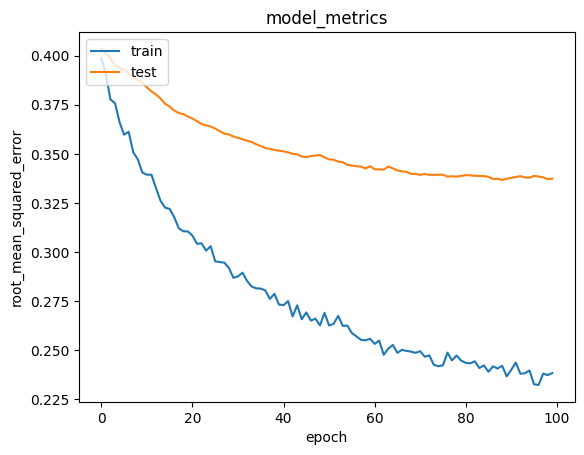

In [ ]:
plt.plot(history.history['root_mean_squared_error'])
plt.plot(history.history['val_root_mean_squared_error'])
plt.title('model_metrics')
plt.ylabel('root_mean_squared_error')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Untuk mendapatkan rekomendasi resto, pertama kita ambil sampel user secara acak dan definisikan variabel resto_not_visited yang merupakan daftar resto yang belum pernah dikunjungi oleh pengguna.

In [ ]:
resto_df = resto_new
df = pd.read_csv('rating_final.csv')

# Mengambil sample user
user_id = df.userID.sample(1).iloc[0]
resto_visited_by_user = df[df.userID == user_id]

# Operator bitwise (~), bisa diketahui di sini https://docs.python.org/3/reference/expressions.html
resto_not_visited = resto_df[~resto_df['id'].isin(resto_visited_by_user.placeID.values)]['id']
resto_not_visited = list(
    set(resto_not_visited)
    .intersection(set(resto_to_resto_encoded.keys()))
)

resto_not_visited = [[resto_to_resto_encoded.get(x)] for x in resto_not_visited]
user_encoder = user_to_user_encoded.get(user_id)
user_resto_array = np.hstack(
    ([[user_encoder]] * len(resto_not_visited), resto_not_visited)
)

In [ ]:
ratings = model.predict(user_resto_array).flatten()

top_ratings_indices = ratings.argsort()[-10:][::-1]
recommended_resto_ids = [
    resto_encoded_to_resto.get(resto_not_visited[x][0]) for x in top_ratings_indices
]

print('Showing recommendations for users: {}'.format(user_id))
print('===' * 9)
print('Resto with high ratings from user')
print('----' * 8)

top_resto_user = (
    resto_visited_by_user.sort_values(
        by = 'rating',
        ascending=False
    )
    .head(5)
    .placeID.values
)

resto_df_rows = resto_df[resto_df['id'].isin(top_resto_user)]
for row in resto_df_rows.itertuples():
    print(row.resto_name, ':', row.cuisine)

print('----' * 8)
print('Top 10 resto recommendation')
print('----' * 8)

recommended_resto = resto_df[resto_df['id'].isin(recommended_resto_ids)]
for row in recommended_resto.itertuples():
    print(row.resto_name, ':', row.cuisine)

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 382ms/step
Showing recommendations for users: U1082
Resto with high ratings from user
--------------------------------
tacos de barbacoa enfrente del Tec : Mexican
Hamburguesas La perica : Mexican
Pollo_Frito_Buenos_Aires : Fast_Food
carnitas_mata : Mexican
palomo tec : Mexican
--------------------------------
Top 10 resto recommendation
--------------------------------
La Estrella de Dimas : Mexican
cafe punta del cielo : Cafeteria
rockabilly  : Bar
emilianos : Bar_Pub_Brewery
Restaurant Las Mananitas : International
Kiku Cuernavaca : Japanese
El Oceano Dorado : Mexican
El Rincon de San Francisco : Mexican
Preambulo Wifi Zone Cafe : Cafeteria
Michiko Restaurant Japones : Japanese
